# Using the Pharaglow-Analysis toolset for data analysis

In [12]:
import pg_analysis
import pg_analysis.plotter as pga
import matplotlib.pylab as plt
from pg_analysis import style
import numpy as np
import importlib
importlib.reload(pg_analysis.plotter)

<module 'pg_analysis.plotter' from '/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py'>

In [15]:
pwd

'/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis'

In [47]:
data.samples = control.samples

## Loading data

In [46]:
# load data from pharaglow results file
cols = ['x', 'y', 'frame', 'pumps', 'area', 'Centerline']
units = {'x':'px', 'y':'px', 'frame':'1', 'pumps':'a.f.u.','area': 'px^2','Area2':'px^2', 'Centerline':'px' }

data = pga.Experiment(strain='GRU101', condition='Entry', scale=2.34, fps = 30., scale_units = 'um', fps_units = 's')
# note the use of filterword to avoid other files in this directory. we can get very specific here.
data.load_data('/gpfs/soma_interim/home/scholz/Data/PG_Test_out/', filterword = 'results_', units = units)

# ... or load from a previously pickled Experiment object.
control = pga.Experiment.load('Test')

# ... we can also dump a pickle object to save the current state of the Experiment variable.
#data.dump('Test')

Reading /gpfs/soma_interim/home/scholz/Data/PG_Test_out/MS0006_0_1000frames_results_4.json
Reading /gpfs/soma_interim/home/scholz/Data/PG_Test_out/MS0006_0_1000frames_results_5.json
Reading /gpfs/soma_interim/home/scholz/Data/PG_Test_out/MS0006_0_1000frames_results_1.json
Reading /gpfs/soma_interim/home/scholz/Data/PG_Test_out/MS0006_0_1000frames_results_2.json
Reading /gpfs/soma_interim/home/scholz/Data/PG_Test_out/MS0006_0_1000frames_results_0.json


## Exploring the Experiment object
An Experiment object is a container for the Worm object. Each worm object contains the phargalow data table. You can print either the Experiment or a single worm to get a description.

In [48]:
print(data)
#the class supports slicing
# get just a few samples. a is still an Experiment object
a = data[0:2]
# it also allows addition if you loaded two objects for example.
a = data[0]+data[1]
# if you want to access the underlying worm class, use get_sample(n) 
w = data.get_sample(0)
print(w)

Experiment 
 Strain: GRU101,
 Condition: Entry
 N = 4.
Worm 
 with underlying data:                  x           y        frame       pumps        time  \
count   774.000000  774.000000   774.000000  774.000000  774.000000   
mean   1423.858933  285.627615  8054.500000  -50.574022  268.483333   
std      11.632366   26.403919   223.578845   11.518238    7.452628   
min    1400.670659  245.496434  7668.000000 -106.427193  255.600000   
25%    1413.478232  262.808890  7861.250000  -53.478518  262.041667   
50%    1425.862977  270.100597  8054.500000  -47.145220  268.483333   
75%    1433.112748  314.757423  8247.750000  -43.854463  274.925000   
max    1448.593750  336.406746  8441.000000  -32.118093  281.366667   

         velocity  pump_clean        rate  pump_events  
count  773.000000  774.000000  774.000000   774.000000  
mean    55.485838    0.000650    2.238607     0.060724  
std     57.440779    2.277268    1.672871     0.238977  
min      1.047382  -13.166139    0.517241     0.

## Calculating additional columns

The loader only load the basic data table. From there one, we have some pre-built methods to calculate other interesting features. 

In [49]:
#extra stuff - real units of time
data.calculate_property("time")
#extra stuff - real unit velocity
data.calculate_property("velocity", units='um/s')
# extra stuff
data.calculate_property('preprocess_signal', key='pumps', w_outlier=None, w_bg=30, w_smooth=2)
ppars = {'sensitivity' : 0.999, 'min_distance' : 4, 'adaptive_window':120}
data.calculate_property("pumps", key='pumps_clean', **ppars)
#extra stuff
data.calculate_property("count_rate",  window = 300)
#extra stuff
data.calculate_property("reversals", animal_size = 100, angle_threshold=150)
#extra stuff
data.calculate_property("reversals_nose", angle_threshold=120, dt = 5, w_smooth = 30, min_duration = 15)

default


AttributeError: 'Worm' object has no attribute 'units'

In [37]:
print(data)

Experiment 
 Strain: GRU101,
 Condition: lawn entry
 N = 4.


### 4. Aligning data temporally

In [33]:
# to align all worms in an experiment to a global timepoint
control.align_data(timepoints = [100], tau_before = 300, tau_after = 300, key = None)
# or align each worm to its own timepoint - here we use the time of lawn entry
tmp = []
for worm in data.samples:
    inside = worm.get_data('inside')
    # make sure it is not always outside the lawn or inside the lawn
    if 0 < np.mean(inside)< 1:
        # get timepoint using the 'insideHead' variable
        tp = worm.get_data('frame').iloc[np.where(worm.get_data('inside')==1)[0][0]]
        if tp>worm.get_data('frame').min():
            worm.multi_align([tp], tau_before=300, tau_after=300, key = None)
            tmp.append(worm)
# make a smaller dataset with just entering worms by using only the entering worms as samples
control.samples = tmp

ValueError: No objects to concatenate

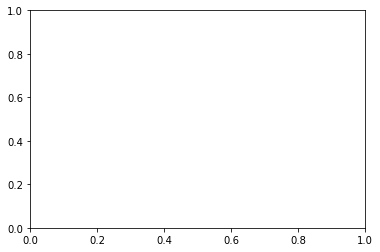

In [34]:
control.plot(plt.gca(), ('x', 'y'), metric = None, plot_type = 'line', color = 'C0', alpha = 0.2)
[plt.plot(w.get_aligned_metric('x', 'mean').loc[0], w.get_aligned_metric('y', 'mean').loc[0], 'rx') for w in control.samples];

### 5. Getting data out

In [35]:
######################################
#
#    calculate metrics at the worm level or experiment level
#
#######################################
# # metric at the worm level, eg. average velocity
w = control.get_sample(0)
for m in ['mean', 'sem', 'std', 'N']:
    t = w.get_metric('velocity', m)
    print(m, t)


# # metric at the experiment level.
plt.figure()
key = 'velocity'
for i, metric in enumerate(['mean', 'sem', 'std', 'N']):
    plt.subplot(2,2,i+1)
    t = control.get_aligned_sample_metric(key, metric, 'mean')
    plt.plot(t, color = 'C0', alpha = 0.1)
    plt.ylabel(f"{metric} {key}")
    
key = 'velocity'
for i, metric in enumerate(['mean', 'sem', 'std', 'N']):
    plt.subplot(2,2,i+1)
    t = control.get_aligned_sample_metric(key, metric, 'mean')
    plt.plot(t, color = 'C0', alpha = 1)
    plt.ylabel(f"{metric} {key}")
plt.tight_layout()

IndexError: list index out of range

### 5. Plotting utilities

/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:950: UserWarning: This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.
  warnings.warn('This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.')


ValueError: No objects to concatenate

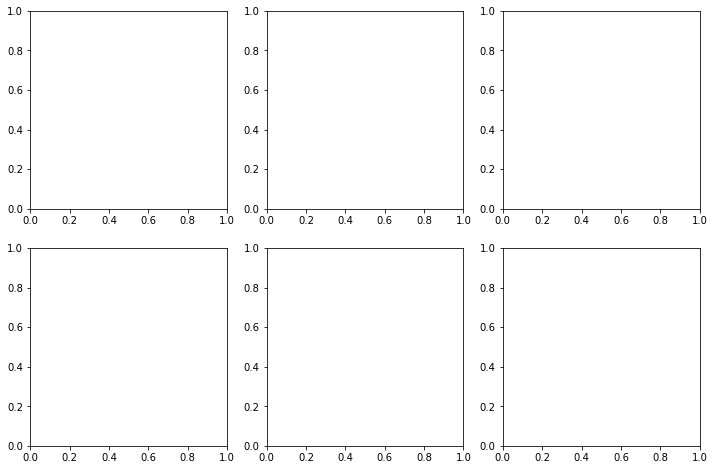

In [36]:
# basic plot types
fig, ((ax1, ax2, ax3), ( ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize = (12, 8))
key_x = 'time'
key_y = 'velocity'

plot, x, y = control.plot(ax1, (key_x, key_y), metric = None, metric_sample = 'mean', plot_type = 'line', metric_error = 'std')
plot, x, y = control.plot(ax2, (key_x, key_y),metric = 'mean', metric_sample = None, plot_type = 'box', loc = 0,)
plot, x, y = control.plot(ax3, ('rate', key_y), metric = 'mean', metric_sample = None, plot_type = 'xy_error_scatter', metric_error = 'sem', marker=None)
plot, x, y = control.plot(ax4, ('rate', key_y), metric = None, metric_sample = 'mean', plot_type = 'density', metric_error = None)
plot, x, y = control.plot(ax5, (key_x, key_y), metric = 'mean', metric_sample = None, plot_type = 'scatter', metric_error = 'std')
plot, x, y = control.plot(ax6, key_y, metric = 'mean', metric_sample = None, plot_type = 'histogram', nbins =range(0,200))

#### Box plots - summary stats

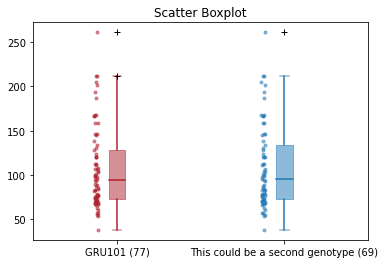

In [17]:
# box plots!
plt.figure()
ax = plt.subplot(111)
ax.set_title('Scatter Boxplot')
# you can filter results by row = here it would be applied before averaging such that individual worms are removed.
control.set_color(style.R1)
plot1, x1, y1 = control.plot(ax, 'velocity',metric = 'mean',  plot_type = 'box', loc = 0, filterfunction = lambda x: np.any(x>300))
N1 = len(y)
# slicing makes a copy! Note how the object doesn't have the same color
plot2, x2, y2 = control[10:100].plot(ax, 'velocity',metric = 'mean', plot_type = 'box', loc = 1, filterfunction = lambda x: np.any(x>0))
# need to add our labels back when doing two plots
ax.set_xticks([0,1])
ax.set_xticklabels([f'GRU101 ({len(y1)})', f'This could be a second genotype ({len(y2)})'])
plt.show()

#### 2D - density and lineplots

/home/mscholz/Desktop/Code/PharaglowAnalysis/pg_analysis/plotter.py:537: UserWarning: This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.
  warnings.warn('This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.')
/home/mscholz/anaconda3/envs/basic/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/mscholz/Desktop/Code/PharaglowAnalysis/pg_analysis/style.py:274: UserWarning: The following kwargs were not used by contour: 'color'
  cfset = ax.contourf(xx, yy, f, **kwargs)


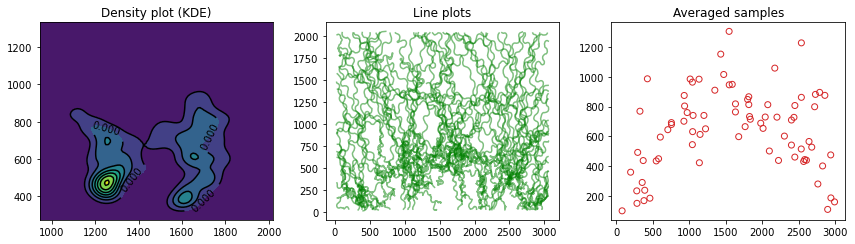

In [18]:
plt.figure(figsize = (12,3.5))
ax = plt.subplot(131)
ax.set_title('Density plot (KDE)')
plot, x, y = control.plot(ax, ('x', 'y'), metric = None, metric_sample = 'mean', plot_type = 'density', metric_error = None)
ax = plt.subplot(132)
ax.set_title('Line plots')
control.plot(ax, ('x', 'y'), metric = None,  alpha = 0.5, color = 'green')
ax = plt.subplot(133)
ax.set_title('Averaged samples')
control.plot(ax, ('x', 'y'), metric = 'mean', plot_type = 'scatter', marker = 'o',facecolor='none',edgecolor='C3')
plt.tight_layout()

#### Scatter in multiple plots

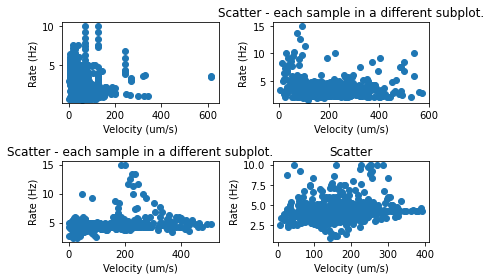

In [4]:
# scatter two variables against each other with different subplot options
plt.figure()
ax0 = plt.subplot(221)
ax1 = plt.subplot(222)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)
axes = [ax0, ax1, ax2, ax3]
for ax in axes:
    ax.set_ylabel('Rate (Hz)')
    ax.set_xlabel('Velocity (um/s)')
ax.set_title('Scatter')
control[:4].plot(axes, ('velocity', 'rate'), metric = None, metric_sample = None, plot_type='scatter')
ax1.set_title('Scatter - each sample in a different subplot.')
ax2.set_title('Scatter - each sample in a different subplot.')

plt.tight_layout()

#### Timeseries

/home/mscholz/Desktop/Code/PharaglowAnalysis/pg_analysis/plotter.py:537: UserWarning: This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.
  warnings.warn('This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.')


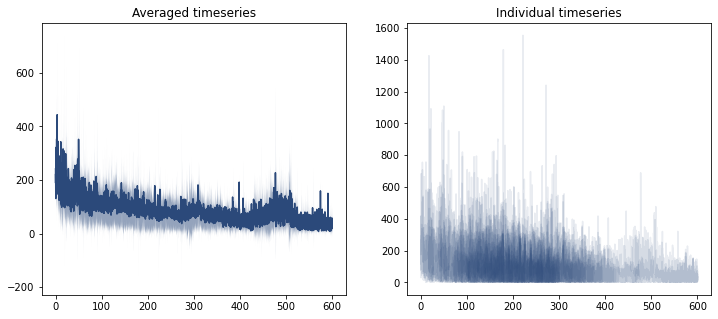

In [20]:
plt.figure(figsize = (12, 5))
control.set_color(style.B1)
ax1 = plt.subplot(121)
ax1.set_title('Averaged timeseries')
control.plot(ax1, 'velocity',  metric = None, metric_sample = 'mean', metric_error = 'std');
ax2 = plt.subplot(122)
ax2.set_title('Individual timeseries')
control.plot(ax2, 'velocity', metric = None, alpha = 0.1);